In [1]:
import pickle
import pandas as pd
from tqdm import tqdm
import os
from collections import defaultdict, Counter
from scipy import sparse, stats
import numpy as np
from sklearn.linear_model import LogisticRegression
import json
from copy import copy
from scipy.special import expit
import matplotlib.pyplot as plt

print(os.getcwd())
os.chdir("2sem/nikolenko/advanced-ml-2022-main/HW2")
print(os.getcwd())

/home/andrey/PycharmProjects/Made
/home/andrey/PycharmProjects/Made/2sem/nikolenko/advanced-ml-2022-main/HW2


# 1. Data Overview

Прочитайте и проанализируйте данные, выберите турниры, в которых есть данные о составах команд и повопросных результатах (поле mask в results.pkl). Для унификации предлагаю:
взять в тренировочный набор турниры с dateStart из 2019 года;
в тестовый — турниры с dateStart из 2020 года.


In [11]:
print(os.getcwd())

with open("tournaments.pkl", "rb") as f:
    tournaments = pickle.load(f)

with open("results.pkl", "rb") as f:
    results = pickle.load(f)

with open('players.pkl', 'rb') as f:
    players = pickle.load(f)


/home/andrey/PycharmProjects/Made/2sem/nikolenko/advanced-ml-2022-main/HW2


Choose correct tournaments from tournaments

In [12]:
train_tournaments_ids = []
test_tournaments_ids = []

train_start_date = pd.to_datetime("2019/01/01 00:00:00", utc=True)
train_end_date = pd.to_datetime("2019/12/31 23:59:59", utc=True)

test_start_date = pd.to_datetime("2020/01/01 00:00:00", utc=True)
test_end_date = pd.to_datetime("2020/12/31 23:59:59", utc=True)

for key, val in tournaments.items():
    if train_end_date >= pd.to_datetime(val["dateStart"]) >= train_start_date:
        train_tournaments_ids.append(val["id"])
    elif test_end_date >= pd.to_datetime(val["dateStart"]) >= test_start_date:
        test_tournaments_ids.append(val["id"])

print(train_tournaments_ids[:10])
print(test_tournaments_ids[:10])


[4772, 4973, 4974, 4975, 4986, 5000, 5008, 5009, 5010, 5011]
[4628, 4957, 5151, 5414, 5477, 5619, 5670, 5694, 5707, 5708]


In [23]:
train_dataset = []

for ind in train_tournaments_ids:
    val = results[ind]
    small_train = {"id" : ind}
    small_teams = []
    #print(small_train)
    for single_team in val:
        single_rec = {}
        single_rec["id"] = single_team["team"]["id"]
        team_members = single_team.get("teamMembers")
        mask = single_team.get("mask")
        if (not mask is None) and (not team_members is None):
            single_rec["mask"] = [int(el) if el.isnumeric() else 0 for el in mask]
            if single_rec["mask"][0] is None:
                break
            players_list = []
            for pl in single_team["teamMembers"]:
                players_list.append(pl["player"]["id"])
            single_rec["members"] = players_list
            small_teams.append(single_rec)

    if small_teams != []:
        small_train["teams"] = small_teams
        train_dataset.append(small_train)

    #break

In [24]:
train_dataset[0]

{'id': 4772,
 'teams': [{'id': 45556,
   'mask': [1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    0,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    0,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    0,
    0,
    0,
    1,
    0,
    0,
    1,
    0],
   'members': [6212, 18332, 18036, 22799, 15456, 26089]},
  {'id': 1030,
   'mask': [1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    0,
    1,
    1,
    1,
    1,
    0,
    1,
    0,
    0,
    1,
    0,
    1,
    1,
    1,
    1,
    0,
    1,
    1,
    0,
    0,
    1,
    0,
    1,
    1,
    0,
    1,
    0],
   'members': [1585, 40840, 1584, 10998, 16206]},
  {'id': 4252,
   'mask': [1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    0,
    1,
    1,
    1,
    1,
    0,
    1,
    0,
    1,
    1,
    0,
    1,
    1,
    1,
    1,
    0,
    0,
    1,
    0,
    1,
    1,
    1,
    1,
    0,
    0,
    0,
    0],
   'members': [23513, 18168, 21060, 35850

In [13]:
test_dataset = []

for ind in test_tournaments_ids:
    val = results[ind]
    small_train = {"id" : ind}
    small_teams = []
    #print(small_train)
    for single_team in val:
        single_rec = {}
        single_rec["id"] = single_team["team"]["id"]
        team_members = single_team.get("teamMembers")
        mask = single_team.get("mask")
        if (not mask is None) and (not team_members is None):
            single_rec["mask"] = [int(el) if el.isnumeric() else 0 for el in mask]
            if single_rec["mask"][0] is None:
                break
            players_list = []
            for pl in single_team["teamMembers"]:
                players_list.append(pl["player"]["id"])
            single_rec["members"] = players_list
            small_teams.append(single_rec)

    if small_teams != []:
        small_train["teams"] = small_teams
        test_dataset.append(small_train)

    #break

In [26]:
test_dataset[0]

{'id': 4957,
 'teams': [{'id': 49804,
   'mask': [1,
    1,
    1,
    1,
    1,
    1,
    0,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    0,
    1,
    1,
    0,
    None,
    1,
    1,
    1,
    0,
    1,
    1,
    1,
    1,
    0,
    0,
    0,
    1,
    0,
    1,
    0,
    1,
    0,
    0,
    0,
    1],
   'members': [30152, 30270, 27822, 28751, 27403, 4270]},
  {'id': 4109,
   'mask': [1,
    0,
    1,
    1,
    1,
    1,
    0,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    0,
    1,
    0,
    0,
    None,
    0,
    0,
    1,
    1,
    1,
    1,
    1,
    1,
    0,
    1,
    1,
    1,
    0,
    0,
    0,
    1,
    0,
    1,
    0,
    0],
   'members': [34936, 40877, 25177, 113703, 33792, 107161]},
  {'id': 3875,
   'mask': [1,
    0,
    1,
    1,
    1,
    0,
    1,
    0,
    1,
    0,
    1,
    1,
    0,
    1,
    0,
    0,
    0,
    0,
    None,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    0,
    1,
    0,
    0,
 

In [14]:
with open("train.json", "w") as file:
    json.dump(train_dataset, file)

with open("test.json", "w") as file:
    json.dump(test_dataset, file)

In [2]:
with open("train.json", "r") as file:
    train_dataset = json.load(file)

with open("test.json", "r") as file:
    test_dataset = json.load(file)


In [20]:
with open("tournaments.pkl", "rb") as f:
    tournaments = pickle.load(f)

In [3]:
with open('players.pkl', 'rb') as f:
    players = pickle.load(f)

players_names = {}

for key, val in players.items():
    players_names[val["id"]] = val["surname"] + " " + val["name"]

sec_players_dict = Counter()
answers_counts = defaultdict(list)

for tournament in train_dataset:
    for team in tournament["teams"]:
        small_players = team["members"]
        n_questions = len(team["mask"])
        for single_player in small_players:
            sec_players_dict[single_player] += 1
            answers_counts[single_player].append(n_questions)

player_to_idx = {player: ind for ind, player in enumerate(sec_players_dict)}

n_players = len(players_names)

players_names

{1: 'Абабилов Алексей',
 10: 'Абалов Игорь',
 11: 'Абалымова Наталья',
 12: 'Абальян Артур',
 13: 'Абальян Эрик',
 14: 'Абанин Василий',
 15: 'Абарников Олег',
 16: 'Абасалиев Азер',
 17: 'Абасев А.',
 18: 'Аббасханов Гияс',
 19: 'Абашев Александр',
 20: 'Абашин Владимир',
 21: 'Абашин Павел',
 22: 'Абашин Павел',
 23: 'Абащенко Андрей',
 25: 'Аббасов Азер',
 26: 'Аббасов Алексей',
 27: 'Аббасов Гашам',
 29: 'Аббасов Низами',
 30: 'Аббасов Орхан',
 31: 'Абасова Ситара',
 33: 'Аббясов Аник',
 34: 'Аббясова Венера',
 35: 'Абгарян Нарек',
 36: 'Абдалла Хасан-Ахмад-Амин',
 37: 'Абдалов Егор',
 38: 'Абдеев Эдуард',
 39: 'Авдеева Яна',
 40: 'Абдикалыков Абдикожа',
 41: 'Абдрахманов Айдар',
 42: 'Абдрахманов Андрей',
 43: 'Абдрахманов Артур',
 44: 'Абдрахманов Радик',
 45: 'Абдрахманов Ринат',
 46: 'Абдрахманова Аделя',
 47: 'Абдрахманова Алёна',
 48: 'Абдрахманова Ляйсан',
 49: 'Абдрашитов Айрат',
 50: 'Абдрашитов Рифат',
 51: 'Абдрашитова Ирина',
 52: 'Абдрашитова Элина',
 53: 'Абдужамалова

# 2. Baseline model

Постройте baseline-модель на основе линейной или логистической регрессии, которая будет обучать рейтинг-лист игроков. Замечания и подсказки:
повопросные результаты — это фактически результаты броска монетки, и их предсказание скорее всего имеет отношение к бинарной классификации;
в разных турнирах вопросы совсем разного уровня сложности, поэтому модель должна это учитывать; скорее всего, модель должна будет явно обучать не только силу каждого игрока, но и сложность каждого вопроса;
для baseline-модели можно забыть о командах и считать, что повопросные результаты команды просто относятся к каждому из её игроков.


In [4]:
y, positions, team_ids, questions_idx = \
    [], [], [], []

hor_ind = 0
vert_ind = 0

for tournament in train_dataset:
    for team in tournament["teams"]:
        players = team["members"]
        mask = team["mask"]
        for i, question in enumerate(mask):
            questions_idx += [len(player_to_idx) + vert_ind for _ in range(len(players))]
            team_ids += [team["id"] for _ in range(len(players))]
            for j, player in enumerate(players):
                positions.append((hor_ind, player_to_idx[player]))
                positions.append((hor_ind, len(player_to_idx) + vert_ind))
                hor_ind += 1
                y.append(1 if question else 0)
            vert_ind += 1


In [5]:
y = np.array(y)
X = sparse.lil_matrix((len(y), n_players + vert_ind))
for i, j in positions:
    X[i, j] = 1

X.shape

(21112007, 4051626)

In [6]:
logreg = LogisticRegression(tol=1e-1, solver="saga", C=1, penalty="l2", )
logreg.fit(X, y)

LogisticRegression(C=1, solver='saga', tol=0.1)

In [18]:
N_QUESTIONS = 2000

question_rating = logreg.coef_[0][n_players:]
rating = logreg.coef_[0][:n_players]
rating_list = []
for ind, pl in enumerate(player_to_idx):
    if sum(answers_counts[pl]) < N_QUESTIONS:
        continue
    single_rec = {"id": pl,
                    "name": players_names[pl],
                    "questions": sum(answers_counts[pl]),
                    "score": rating[ind],
    }
    rating_list.append(single_rec)

sorted_rating = sorted(rating_list, key=lambda x: x['score'], reverse=True)
df_rating = pd.DataFrame(sorted_rating)[:50]
df_rating.head(20)

,id,name,questions,score
0,27403,Руссо Максим,2474,2.419816
1,4270,Брутер Александра,3026,2.383945
2,28751,Семушин Иван,4118,2.326579
3,27822,Савченков Михаил,3677,2.229340
4,30270,Спешков Сергей,4190,2.185041
5,30152,Сорожкин Артём,5254,2.146120
6,56647,Горелова Наталья,2357,1.968142
7,7008,Гилёв Алексей,4827,1.903479
8,18332,Либер Александр,4127,1.898742
9,74382,Новосёлов Михаил,3280,1.874220


# 3. Ranking
Качество рейтинг-системы оценивается качеством предсказаний результатов турниров. Но сами повопросные результаты наши модели предсказывать вряд ли смогут, ведь неизвестно, насколько сложными окажутся вопросы в будущих турнирах; да и не нужны эти предсказания сами по себе. Поэтому:
предложите способ предсказать результаты нового турнира с известными составами, но неизвестными вопросами, в виде ранжирования команд;
в качестве метрики качества на тестовом наборе давайте считать ранговые корреляции Спирмена и Кендалла (их можно взять в пакете scipy) между реальным ранжированием в результатах турнира и предсказанным моделью, усреднённые по тестовому множеству турниров.


In [8]:
test_tours = []
test_rating = []

for tour in test_dataset:
    single_test = []
    single_rating = []
    for team in tour['teams']:
        player = [pl for pl in team['members'] if pl in player_to_idx.keys()]
        team_test = copy(team)
        team_test['members'] = player
        if len(player) > 0:
            single_test.append(team_test)
            team_answers = list(map(int, team['mask']))
            team_score = sum(team_answers)
            single_rating.append(team_score)
    if len(single_test) > 1:
        tournament_test = copy(tour)
        tournament_test['teams'] = single_test
        test_tours.append(tournament_test)
        test_rating.append(single_rating)

In [9]:
print(test_rating[0])

[26, 24, 23, 22, 21, 21, 20, 20, 19, 18, 18, 18, 18, 18, 17, 17, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15, 15, 15, 15, 14, 14, 14, 14, 14, 14, 14, 13, 13, 13, 13, 13, 13, 13, 13, 13, 12, 12, 12, 12, 12, 12, 12, 12, 12, 11, 11, 11, 11, 11, 11, 10, 10, 10, 10, 10, 9, 9, 9, 9, 8, 8, 8, 8, 8, 7, 7, 7, 6, 5, 4, 4, 4, 4, 3, 2, 2]


In [10]:
def predict_tours(model, tours, player_to_idx, shape_1 = X.shape[1]):
    pred_rating = []
    for tour in tqdm(tours):
        preds = []
        for team in tour['teams']:
            player_idxs = [player_to_idx[pl] for pl in team['members']]
            cnt = len(player_idxs)
            X = sparse.lil_matrix((cnt, shape_1), dtype=int)
            X[range(len(player_idxs)), player_idxs] = 1
            bad_probs = model.predict_proba(X)[:, 0]
            team_proba = 1 - bad_probs.prod()
            preds.append(team_proba)
        pred_rating.append(preds)
    return pred_rating


def calculate_correlations(test_rating, pred_rating):
    spm_list = []
    kndl_list = []
    for i in range(len(test_rating)):
        small_spm = stats.spearmanr(test_rating[i], pred_rating[i]).correlation
        small_kndl = stats.kendalltau(test_rating[i], pred_rating[i]).correlation
        spm_list.append(small_spm)
        kndl_list.append(small_kndl)
    spm = np.mean(spm_list)
    kndl = np.mean(kndl_list)

    return spm, kndl


In [11]:
pred_rating = predict_tours(logreg, test_tours, player_to_idx)

100%|█████████████████████████████████████████████████████████████████████████████████| 170/170 [00:05<00:00, 33.05it/s]


In [12]:
print(pred_rating[0])

[0.9999406098231899, 0.9984047244272874, 0.9973978818593005, 0.9992479189040138, 0.9994273481265412, 0.998438362562185, 0.9995279900889108, 0.9935226217726588, 0.9983035208269844, 0.9959420773667446, 0.9979030260604728, 0.9973088520636284, 0.9953271961175565, 0.9797381546940626, 0.9848876888093143, 0.9950319222215798, 0.99772061827645, 0.9812236193667327, 0.9992013465478473, 0.99485831702787, 0.9631499740848918, 0.9988242300332146, 0.998891050151863, 0.9961039453726247, 0.9665973760815029, 0.9865503932357361, 0.9934725690657921, 0.9925886841235306, 0.9867669033987113, 0.9375573869985419, 0.9911250210631889, 0.996003960395624, 0.9990857572288728, 0.9875905378345654, 0.9337387847721693, 0.8921013812261277, 0.9948111398130838, 0.9885398687773117, 0.9847122305360769, 0.9833808894355864, 0.9964525797796392, 0.9786154178281753, 0.985404556965706, 0.9732164984148898, 0.9653369232512387, 0.9899895397267133, 0.9957060087471126, 0.9958704673169604, 0.9873067347560678, 0.9819328167759358, 0.98692

In [13]:
spm, kndl = calculate_correlations(test_rating, pred_rating)

print(f'Spearman`s correlation: {round(spm, 3)}')
print(f'Kendall`s correlation: {round(kndl, 3)}')

Spearman`s correlation: 0.707
Kendall`s correlation: 0.551


# 4. Many-persons account
Теперь главное: ЧГК — это всё-таки командная игра. Поэтому:
предложите способ учитывать то, что на вопрос отвечают сразу несколько игроков; скорее всего, понадобятся скрытые переменные; не стесняйтесь делать упрощающие предположения, но теперь переменные “игрок X ответил на вопрос Y” при условии данных должны стать зависимыми для игроков одной и той же команды;
разработайте EM-схему для обучения этой модели, реализуйте её в коде;
обучите несколько итераций, убедитесь, что целевые метрики со временем растут (скорее всего, ненамного, но расти должны), выберите лучшую модель, используя целевые метрики.


- Use z as a vector of hidden states -- it consists of player answer porbability provided by team:

$$z = P(member=1|team)$$

- E-step: predict players answers probabilities provided by team:

$$P(member=1|team=1) = \frac{P(member=1 \cap team=1)}{P(team=1)} = \frac{P(team=1 | member=1) P(member=1)}{P(team=1)} = \frac{P(member=1)}{P(team=1)}$$

- M-step: maximize likelihood. Train model on E-step probabilities

In [14]:
class EMProbabilities:
    def __init__(self, model):
        self.w = np.hstack((model.intercept_, model.coef_[0]))

    def fit(self, X, y, max_iters=100_000, lr=10, batch_size=1000, tol=0.0000001):
        X = sparse.hstack([np.ones(len(y)).reshape(-1, 1), X], format='csr')

        losses = []
        prev_mean_loss = np.inf
        data_len = X.shape[0]

        for i in range(max_iters):
            batch_idxs = np.random.choice(data_len, batch_size)
            X_batch = X[batch_idxs, :]
            y_batch = y[batch_idxs]
            preds = expit(X_batch.dot(self.w))
            losses.append(self.log_loss(y_batch, preds))
            if (i + 1) % 1000 == 0:
                new_mean_loss = np.mean(losses)
                if (prev_mean_loss - new_mean_loss) < tol:
                    #print(f'Fitted. Mean NLL: {new_mean_loss}')
                    return new_mean_loss
                    #break
                losses = []
                prev_mean_loss = new_mean_loss

            grad = -X_batch.T.dot(y_batch - preds) / len(y_batch)
            self.w -= lr * grad

    def predict_proba(self, X):
        X = sparse.hstack([np.ones(X.shape[0]).reshape(-1, 1), X])
        preds = expit(X.dot(self.w))
        return np.hstack(((1 - preds).reshape(-1, 1), preds.reshape(-1, 1)))

    @staticmethod
    def log_loss(y, p):
        return -np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))

In [15]:
estimator = EMProbabilities(logreg)

spm_list, kndl_list, nll_list = [], [], []


for i in range(10):
    # E-step
    preds = estimator.predict_proba(X)

    # Probability provided by team
    df_team = pd.DataFrame({'team': team_ids, 'question': questions_idx, 'fail_pred': preds[:, 0], 'success_pred': preds[:, 1]})
    df_team_pis = df_team.groupby(['team', 'question']).agg({'fail_pred': 'prod'}).reset_index()
    df_team_pis['team_success_pred'] = 1 - df_team_pis['fail_pred']
    df_team_pis.drop(columns=['fail_pred'], inplace=True)
    df_team = pd.merge(df_team, df_team_pis, left_on=['team', 'question'],  right_on=['team', 'question'])
    z = (df_team['success_pred'] / df_team['team_success_pred']).clip(0, 1)

    z[y == 0] = 0


    # M-step
    mean_nll = estimator.fit(X, z, lr=20)
    pred_rating = predict_tours(estimator, test_tours, player_to_idx)
    spm, kndl = calculate_correlations(test_rating, pred_rating)

    spm_list.append(spm)
    kndl_list.append(kndl)
    nll_list.append(mean_nll)

    print(f'Spearman`s correlation: {round(spm, 3)}')
    print(f'Kendall`s correlation: {round(kndl, 3)}')
    print(f'Mean NLL: {round(mean_nll, 3)}')

100%|█████████████████████████████████████████████████████████████████████████████████| 170/170 [00:08<00:00, 19.56it/s]


Spearman`s correlation: 0.728
Kendall`s correlation: 0.571
Mean NLL: 0.84


100%|█████████████████████████████████████████████████████████████████████████████████| 170/170 [00:08<00:00, 19.34it/s]


Spearman`s correlation: 0.733
Kendall`s correlation: 0.576
Mean NLL: 0.528


100%|█████████████████████████████████████████████████████████████████████████████████| 170/170 [00:08<00:00, 19.95it/s]


Spearman`s correlation: 0.741
Kendall`s correlation: 0.584
Mean NLL: 0.253


100%|█████████████████████████████████████████████████████████████████████████████████| 170/170 [00:08<00:00, 19.91it/s]


Spearman`s correlation: 0.739
Kendall`s correlation: 0.581
Mean NLL: 0.276


100%|█████████████████████████████████████████████████████████████████████████████████| 170/170 [00:08<00:00, 19.66it/s]


Spearman`s correlation: 0.737
Kendall`s correlation: 0.579
Mean NLL: 0.291


100%|█████████████████████████████████████████████████████████████████████████████████| 170/170 [00:08<00:00, 20.06it/s]


Spearman`s correlation: 0.736
Kendall`s correlation: 0.577
Mean NLL: 0.29


100%|█████████████████████████████████████████████████████████████████████████████████| 170/170 [00:10<00:00, 16.63it/s]


Spearman`s correlation: 0.733
Kendall`s correlation: 0.575
Mean NLL: 0.311


100%|█████████████████████████████████████████████████████████████████████████████████| 170/170 [00:09<00:00, 18.43it/s]


Spearman`s correlation: 0.738
Kendall`s correlation: 0.58
Mean NLL: 0.438


100%|█████████████████████████████████████████████████████████████████████████████████| 170/170 [00:08<00:00, 19.69it/s]


Spearman`s correlation: 0.733
Kendall`s correlation: 0.574
Mean NLL: 0.252


100%|█████████████████████████████████████████████████████████████████████████████████| 170/170 [00:08<00:00, 19.71it/s]


Spearman`s correlation: 0.729
Kendall`s correlation: 0.571
Mean NLL: 0.278


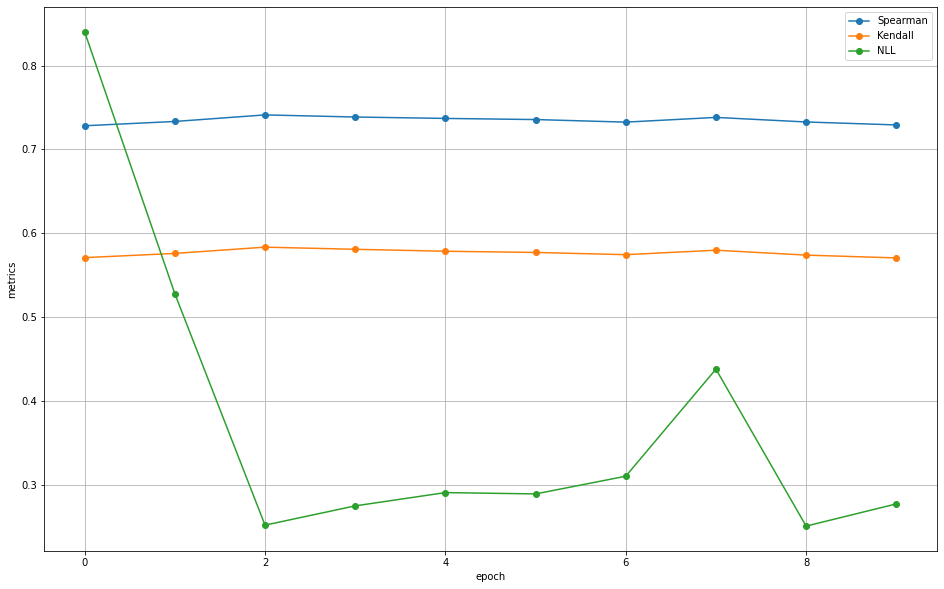

In [16]:
plt.figure(figsize=(16,10))

x_list = np.arange(10)

plt.plot(x_list, spm_list, "o-", label="Spearman")
plt.plot(x_list, kndl_list, "o-", label="Kendall")
plt.plot(x_list, nll_list, "o-", label="NLL")

plt.xlabel("epoch")
plt.ylabel("metrics")
plt.grid(True)
plt.legend()
plt.show()


# 5. Difficulty list

А что там с вопросами? Постройте “рейтинг-лист” турниров по сложности вопросов. Соответствует ли он интуиции (например, на чемпионате мира в целом должны быть сложные вопросы, а на турнирах для школьников — простые)? Если будет интересно: постройте топ сложных и простых вопросов со ссылками на конкретные записи в базе вопросов ЧГК (это чисто техническое дело, тут никакого ML нету).


In [21]:
tournament_rating = dict()
question_to_tour = dict()
questions_count = 0

for tournament in train_dataset:
    tour_questions_count = len(tournament["teams"][0]["mask"])
    start_index, end_index = questions_count, questions_count + tour_questions_count
    tournament_rating[tournament["id"]] = np.sum(question_rating[start_index: end_index])
    for q in range(tour_questions_count):
        question_to_tour[questions_count + q] = {
            "tournament_id": tournament["id"],
            "tournament_name": tournaments[tournament["id"]]["name"],
            "question_num": q + 1,
        }
    questions_count += tour_questions_count

tournament_rating = sorted(tournament_rating.items(), key=lambda x: x[1])
df_tournament_rating = pd.DataFrame(tournament_rating, columns=["id", "rating"]).drop(columns=["rating"])
df_tournament_rating["name"] = df_tournament_rating["id"].apply(lambda x: tournaments[x]["name"])

In [22]:
df_tournament_rating[-10:]

,id,name
667,5833,Memel Cup
668,5847,Байкальский фестиваль
669,6085,Серия Гран-при. Общий зачёт
670,5462,Синхронный Кубок Ростова - общий зачёт
671,5817,Симбирск-Open
672,5781,Горький Октябрь
673,6090,Дзержинский марафон
674,5760,Балтийский Берег. Общий зачёт
675,5405,Кавалькада волхвов
676,5827,Шестой киевский марафон. Асинхрон


In [23]:
df_tournament_rating[:10]

,id,name
0,5366,Чемпионат Ростовской области
1,5266,Холодная голова
2,5369,Благородный Дон
3,5185,Игра Первопрестольной. Четвёртый сезон
4,5325,Славянка
5,5384,Поволжская лига
6,5298,Нехрустальная Сова
7,5343,Кубок Физтеха
8,5110,Серия Гран-при. 7 этап. Гран-при России
9,5008,Школьный Синхрон-lite. Выпуск 2.3
